<a href="https://www.kaggle.com/code/srabon2104046/deepfake?scriptVersionId=291776450" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# This Work On Predict a Image Fake or Not Use CNN(Efficientnet-v2)

In [1]:

import os, random, glob, time, json
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
RNG = 42
random.seed(RNG)
np.random.seed(RNG)
import torch
print("torch:", torch.__version__, "cuda:", torch.cuda.is_available())
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)


torch: 2.6.0+cu124 cuda: True
Device: cuda


## List Files And Create Labels (Assume '1' At End Of Filename Mans Fake)

In [2]:
from pathlib import Path

root = Path('/kaggle/input/fake-video-images-dataset/images_from_video_big')

# Collect all images
files = sorted([
    p for p in root.rglob('*') 
    if p.suffix.lower() in {'.jpg', '.jpeg', '.png'}
])

print("Total images:", len(files))

# Create labels based on filename ending
labels = []
for f in files:
    name = f.stem  # filename without extension
    if name.endswith("1"):
        labels.append(1)      # Fake
    else:
        labels.append(0)      # Real

# Check distribution
import pandas as pd
df = pd.DataFrame({
    "path": files,
    "label": labels
})

df.head(), df['label'].value_counts()


Total images: 82621


(                                                path  label
 0  /kaggle/input/fake-video-images-dataset/images...      0
 1  /kaggle/input/fake-video-images-dataset/images...      0
 2  /kaggle/input/fake-video-images-dataset/images...      0
 3  /kaggle/input/fake-video-images-dataset/images...      0
 4  /kaggle/input/fake-video-images-dataset/images...      0,
 label
 0    54412
 1    28209
 Name: count, dtype: int64)

## Overview of the Whole Notebook

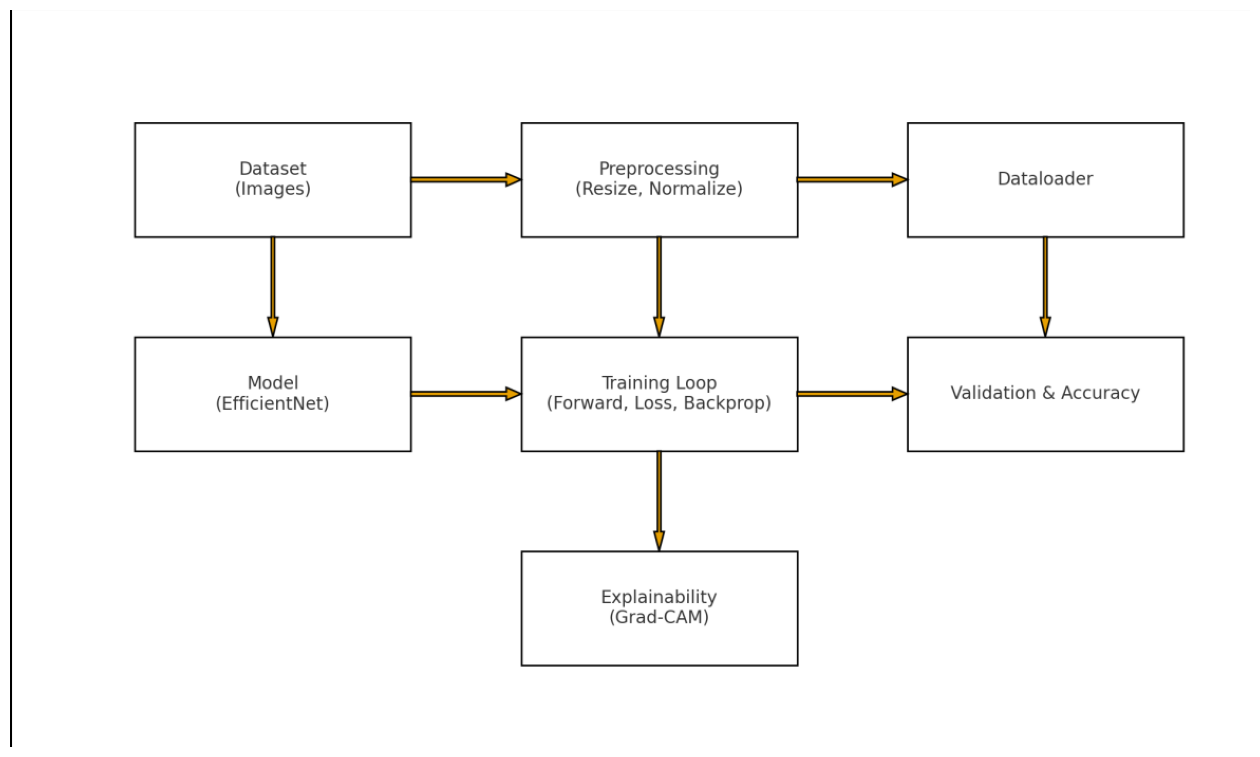

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/kaggle/input/block-diagram/Screenshot from 2025-12-03 09-06-54.png"

img = Image.open(img_path)
plt.figure(figsize=(16, 12))
plt.imshow(img)
plt.axis("off")
plt.show()


# Implementation

## Create Dataframe

In [4]:

rows = []
for p in files:
    name = p.name
    # rule: if filename contains '1' before extension or endswith '1.jpg', treat as fake
    label = 1 if ('1' in Path(name).stem.split('_')[-1] or Path(name).stem.endswith('1')) else 0
    # fallback: if your dataset uses pattern like name_1.jpg, above catches; adjust if needed
    rows.append({'path': str(p), 'filename': name, 'label': label})
df = pd.DataFrame(rows)
print(df.label.value_counts())
df.head()


label
0    54412
1    28209
Name: count, dtype: int64


,path,filename,label
0,/kaggle/input/fake-video-images-dataset/images...,aaaaqqicldbtmpgcdsuljwmsuznhfwyp_17_0.jpg,0
1,/kaggle/input/fake-video-images-dataset/images...,aaaaqqicldbtmpgcdsuljwmsuznhfwyp_8_0.jpg,0
2,/kaggle/input/fake-video-images-dataset/images...,aabfcxqhroqdyozdaivkuynjrtfkdmgb_1_0.jpg,0
3,/kaggle/input/fake-video-images-dataset/images...,aabfcxqhroqdyozdaivkuynjrtfkdmgb_23_0.jpg,0
4,/kaggle/input/fake-video-images-dataset/images...,aableuqfrycjgdiukncisxcrjrjfpcwq_150_0.jpg,0


## Stratified Split

In [5]:

from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=RNG)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=RNG)
len(train_df), len(val_df), len(test_df), train_df.label.mean(), val_df.label.mean(), test_df.label.mean()


(57834,
 12393,
 12394,
 0.3414254590725179,
 0.34140240458323245,
 0.3414555430046797)

 ## Dataset Class Using Torchvision Transforms & Timm Preprocessing

In [6]:

import torchvision.transforms as T
from PIL import Image
import torch.utils.data as data
import timm

IMG_SIZE = 224  # model input size (change to 256 if you prefer)

# get default mean/std for chosen timm model
model_name = 'tf_efficientnetv2_s'  # changeable to 'swin_base_patch4_window7_224' or 'vit_base_patch16_224'
model_preprocess = timm.data.resolve_data_config({}, model=model_name)
MEAN = model_preprocess.get('mean', (0.485,0.456,0.406))
STD  = model_preprocess.get('std',  (0.229,0.224,0.225))

train_transforms = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    T.RandomHorizontalFlip(),
    T.AutoAugment(policy=T.AutoAugmentPolicy.IMAGENET),  # or RandAugment
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD),
])

val_transforms = T.Compose([
    T.Resize(int(IMG_SIZE*1.14)),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD),
])

class ImageDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['path']).convert('RGB')
        if self.transform: img = self.transform(img)
        label = torch.tensor(row['label'], dtype=torch.float32)
        return img, label, row['path']

BATCH = 32
train_ds = ImageDataset(train_df, transform=train_transforms)
val_ds   = ImageDataset(val_df, transform=val_transforms)
test_ds  = ImageDataset(test_df, transform=val_transforms)

train_dl = data.DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=4, pin_memory=True)
val_dl   = data.DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)
test_dl  = data.DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## Create Model

In [7]:
# Cell 4 — create model
import torch.nn as nn

def create_model(model_name='tf_efficientnetv2_s', pretrained=True):
    m = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')  # return features
    n_features = m.num_features
    head = nn.Sequential(
        nn.Linear(n_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(512, 1)  # binary logits
    )
    model = nn.Sequential(m, head)
    return model

model = create_model(model_name=model_name).to(DEVICE)
print(model)


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Sequential(
  (0): EfficientNet(
    (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(in

## Mixup Utility (simple)

In [8]:
# Cell 6 — mixup utility (simple)
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(DEVICE)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(crit, preds, y_a, y_b, lam):
    return lam * crit(preds, y_a) + (1 - lam) * crit(preds, y_b)


## Training Utilities

In [9]:
 
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, confusion_matrix

criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = GradScaler()


/tmp/ipykernel_47/2700452030.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## Train Fuction

In [10]:
# Cell 7 — train function
import math, tqdm
def train_one_epoch(model, dl, optimizer, scaler, mixup_alpha=0.0):
    model.train()
    running_loss = 0.0
    preds_all = []
    labels_all = []
    pbar = tqdm.tqdm(dl, total=len(dl))
    for imgs, labels, _ in pbar:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE).unsqueeze(1)
        if mixup_alpha > 0:
            imgs, y_a, y_b, lam = mixup_data(imgs, labels, alpha=mixup_alpha)
            with autocast():
                feats = model[0](imgs)
                logits = model[1](feats)
                loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
        else:
            with autocast():
                feats = model[0](imgs)
                logits = model[1](feats)
                loss = criterion(logits, labels)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * imgs.size(0)
        probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
        preds_all.extend(probs.tolist())
        labels_all.extend(labels.detach().cpu().numpy().ravel().tolist())
        pbar.set_description(f"loss:{running_loss/((pbar.n+1)*dl.batch_size):.4f}")
    epoch_loss = running_loss / (len(dl.dataset))
    try:
        auc = roc_auc_score(labels_all, preds_all)
    except:
        auc = 0.0
    return epoch_loss, auc

def validate(model, dl):
    model.eval()
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for imgs, labels, _ in dl:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE).unsqueeze(1)
            with autocast():
                feats = model[0](imgs)
                logits = model[1](feats)
                probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
                preds_all.extend(probs.tolist())
                labels_all.extend(labels.detach().cpu().numpy().ravel().tolist())
    try:
        auc = roc_auc_score(labels_all, preds_all)
    except:
        auc = 0.0
    return auc, preds_all, labels_all


In [11]:
import time

## Training Run

In [12]:
# Cell 8 — training run
EPOCHS = 8
best_auc = 0.0
history = {'train_loss':[], 'train_auc':[], 'val_auc':[]}

for epoch in range(EPOCHS):
    t0 = time.time()
    train_loss, train_auc = train_one_epoch(model, train_dl, optimizer, scaler, mixup_alpha=0.2)
    val_auc, val_preds, val_labels = validate(model, val_dl)
    scheduler.step()
    history['train_loss'].append(train_loss)
    history['train_auc'].append(train_auc)
    history['val_auc'].append(val_auc)
    print(f"Epoch {epoch+1}/{EPOCHS} - train_loss: {train_loss:.4f} train_auc: {train_auc:.4f} val_auc: {val_auc:.4f} time:{time.time()-t0:.1f}s")
    # checkpoint
    os.makedirs('/kaggle/working/runs/exp1', exist_ok=True)
    torch.save({'model_state': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}, '/kaggle/working/runs/exp1/last.pth')
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save({'model_state': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}, '/kaggle/working/runs/exp1/best.pth')
        print("saved best")


  0%|          | 0/1808 [00:00<?, ?it/s]/tmp/ipykernel_47/3951506823.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
loss:0.4707: 100%|██████████| 1808/1808 [06:51<00:00,  4.39it/s]
/tmp/ipykernel_47/3951506823.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/8 - train_loss: 0.4708 train_auc: 0.6883 val_auc: 0.9576 time:436.1s
saved best


  0%|          | 0/1808 [00:00<?, ?it/s]/tmp/ipykernel_47/3951506823.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
loss:0.3728: 100%|██████████| 1808/1808 [06:49<00:00,  4.41it/s]
/tmp/ipykernel_47/3951506823.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/8 - train_loss: 0.3730 train_auc: 0.7251 val_auc: 0.9724 time:431.7s
saved best


  0%|          | 0/1808 [00:00<?, ?it/s]/tmp/ipykernel_47/3951506823.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
loss:0.3334: 100%|██████████| 1808/1808 [06:49<00:00,  4.41it/s]
/tmp/ipykernel_47/3951506823.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/8 - train_loss: 0.3336 train_auc: 0.7338 val_auc: 0.9766 time:431.6s
saved best


  0%|          | 0/1808 [00:00<?, ?it/s]/tmp/ipykernel_47/3951506823.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
loss:0.3062: 100%|██████████| 1808/1808 [06:49<00:00,  4.41it/s]
/tmp/ipykernel_47/3951506823.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/8 - train_loss: 0.3063 train_auc: 0.7317 val_auc: 0.9835 time:431.7s
saved best


  0%|          | 0/1808 [00:00<?, ?it/s]/tmp/ipykernel_47/3951506823.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
loss:0.2887: 100%|██████████| 1808/1808 [06:49<00:00,  4.41it/s]
/tmp/ipykernel_47/3951506823.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/8 - train_loss: 0.2888 train_auc: 0.7291 val_auc: 0.9850 time:431.5s
saved best


  0%|          | 0/1808 [00:00<?, ?it/s]/tmp/ipykernel_47/3951506823.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
loss:0.2680: 100%|██████████| 1808/1808 [06:50<00:00,  4.41it/s]
/tmp/ipykernel_47/3951506823.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/8 - train_loss: 0.2681 train_auc: 0.7637 val_auc: 0.9849 time:432.0s


  0%|          | 0/1808 [00:00<?, ?it/s]/tmp/ipykernel_47/3951506823.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
loss:0.2489: 100%|██████████| 1808/1808 [06:51<00:00,  4.40it/s]
/tmp/ipykernel_47/3951506823.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/8 - train_loss: 0.2490 train_auc: 0.7456 val_auc: 0.9872 time:433.0s
saved best


  0%|          | 0/1808 [00:00<?, ?it/s]/tmp/ipykernel_47/3951506823.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
loss:0.2376: 100%|██████████| 1808/1808 [06:51<00:00,  4.40it/s]
/tmp/ipykernel_47/3951506823.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/8 - train_loss: 0.2377 train_auc: 0.7475 val_auc: 0.9878 time:433.3s
saved best


In [13]:
torch.save(model.state_dict(), "/kaggle/working/DEEPFake_effectivenetv2.pth")


 ## ROC on Val

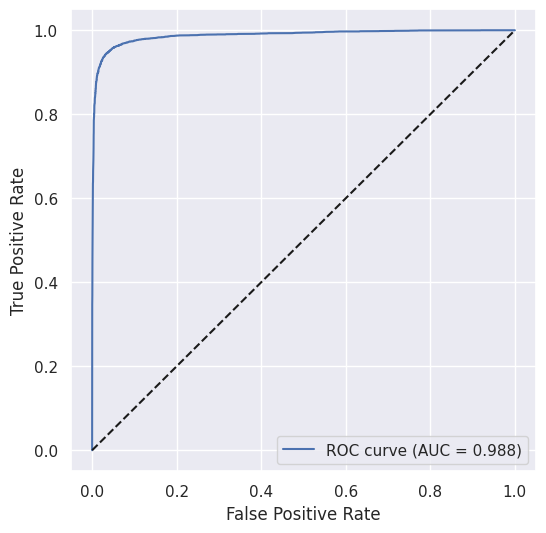

In [14]:
# ROC on val
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(val_labels, val_preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.legend()
plt.savefig('/kaggle/working/runs/exp1/roc_val.png')
plt.show()


## Plots

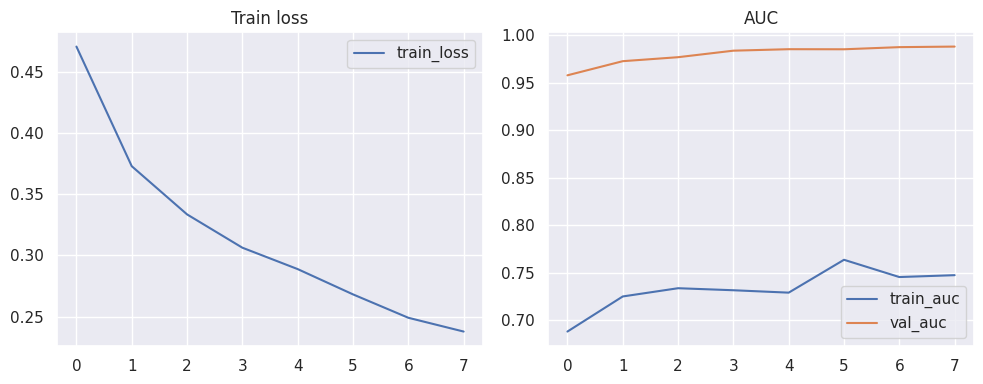

In [15]:
# Cell 9 — plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.title('Train loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history['train_auc'], label='train_auc'); plt.plot(history['val_auc'], label='val_auc')
plt.title('AUC'); plt.legend()
plt.tight_layout()
plt.savefig('/kaggle/working/runs/exp1/training_curves.png')
plt.show()


## This Graph Shows That My Model smoothly Performs Well ( Nor under or Overfit  and fllows Bias varience treadoff)

## Confusion Matrix (use threshold 0.5)

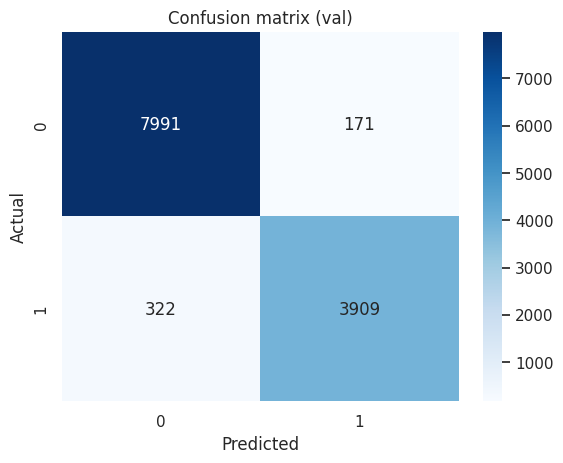

              precision    recall  f1-score   support

         0.0     0.9613    0.9790    0.9701      8162
         1.0     0.9581    0.9239    0.9407      4231

    accuracy                         0.9602     12393
   macro avg     0.9597    0.9515    0.9554     12393
weighted avg     0.9602    0.9602    0.9600     12393



In [16]:
# Cell 10 — confusion matrix (use threshold 0.5)
preds_bin = (np.array(val_preds) >= 0.5).astype(int)
cm = confusion_matrix(val_labels, preds_bin)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion matrix (val)')
plt.savefig('/kaggle/working/runs/exp1/confusion_val.png')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(val_labels, preds_bin, digits=4))


## Get Embeddings From Model Backbone

In [17]:
# Cell 11 — get embeddings from model backbone
def extract_embeddings(model, dl):
    model.eval()
    embs = []
    labs = []
    paths = []
    with torch.no_grad():
        for imgs, labels, pths in dl:
            imgs = imgs.to(DEVICE)
            feats = model[0](imgs)  # backbone features (global avg pooled)
            feats = feats.detach().cpu().numpy()
            embs.append(feats)
            labs.extend(labels.numpy().tolist())
            paths.extend(pths)
    embs = np.vstack(embs)
    return embs, np.array(labs), paths

embs, labs, pths = extract_embeddings(model, val_dl)
embs.shape


(12393, 1280)

## Print T_SNE

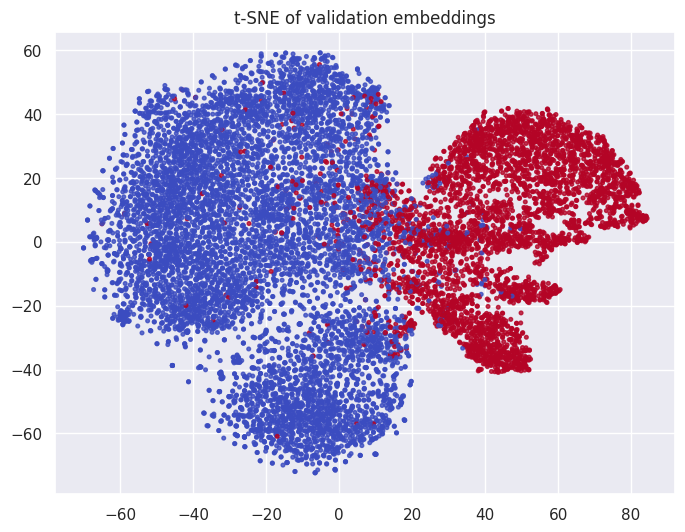

In [18]:

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=RNG, perplexity=40, n_iter=1000)
emb2 = tsne.fit_transform(embs)
plt.figure(figsize=(8,6))
plt.scatter(emb2[:,0], emb2[:,1], c=labs, cmap='coolwarm', s=7, alpha=0.8)
plt.title('t-SNE of validation embeddings')
plt.savefig('/kaggle/working/runs/exp1/tsne_val.png')
plt.show()


## t-SNE (t-distributed Stochastic Neighbor Embedding) Shows Higher Dimension Data In Lower Dimension (2D here) 

In [19]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.6 MB/s eta 0:00:00

Using target layer: [Conv2d(256, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)]


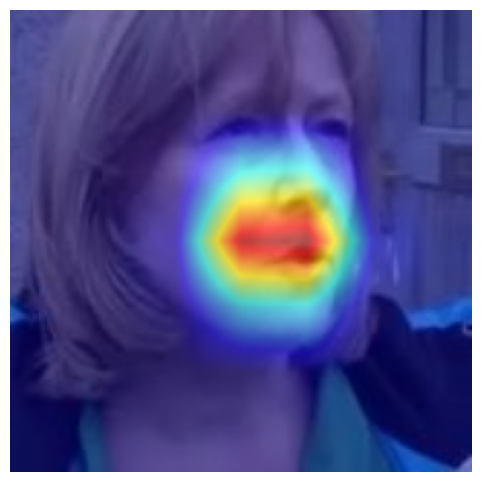

In [20]:
# ------------------------------
# Grad-CAM for any PyTorch CNN
# ------------------------------

import cv2
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt

# ------------------------------
# Settings
# ------------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# ------------------------------
# Function to find last Conv2d layer
# ------------------------------
def find_last_conv_layer(model):
    last_conv = None
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            last_conv = module
    if last_conv is None:
        raise ValueError("No Conv2d layer found in the model")
    return last_conv

# ------------------------------
# Grad-CAM Function
# ------------------------------
def generate_gradcam(path, model, class_idx=None):
    model.eval()
    
    # Read and preprocess image
    img = cv2.imread(str(path))
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    rgb_float = img_resized.astype(np.float32) / 255.0

    pil_img = Image.fromarray(img_resized.astype(np.uint8))
    input_tensor = val_transforms(pil_img).unsqueeze(0).to(DEVICE)

    # Automatically find last conv layer
    target_layers = [find_last_conv_layer(model)]
    print("Using target layer:", target_layers)

    # Determine class
    if class_idx is None:
        with torch.no_grad():
            outputs = model(input_tensor)
            class_idx = outputs.argmax(dim=1).item()

    targets = [ClassifierOutputTarget(class_idx)]

    # Grad-CAM
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Overlay heatmap
    cam_image = show_cam_on_image(rgb_float, grayscale_cam, use_rgb=True)
    
    return cam_image

# ------------------------------
# Example Usage
# ------------------------------
img_path = "/kaggle/input/fake-video-images-dataset/images_from_video_big/aadxylgzpftciastmufdwstwlnhjtbaq_20_1.jpg"

cam_img = generate_gradcam(img_path, model)

# Display
plt.figure(figsize=(6,6))
plt.imshow(cam_img)
plt.axis("off")
plt.show()


Using target layer: [Conv2d(256, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)]


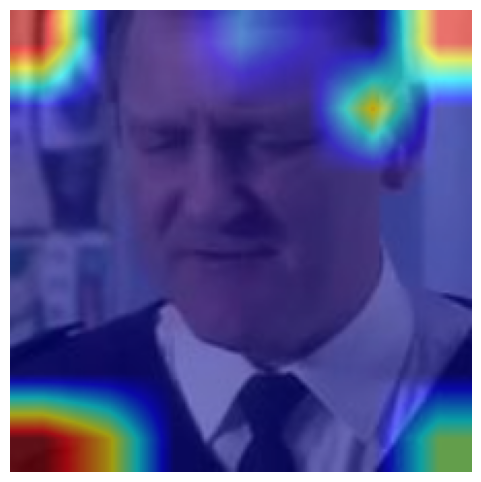

In [21]:
img_path = "/kaggle/input/fake-video-images-dataset/images_from_video_big/aadzsjiglhketcfgmjcwtxfbtekbfzpp_26_0.jpg"

cam_img = generate_gradcam(img_path, model)

# Display
plt.figure(figsize=(6,6))
plt.imshow(cam_img)
plt.axis("off")
plt.show()


## Examples on GRADCAM  How Model predict The Portion Of  Fack Image

Using target layer: [Conv2d(256, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)]


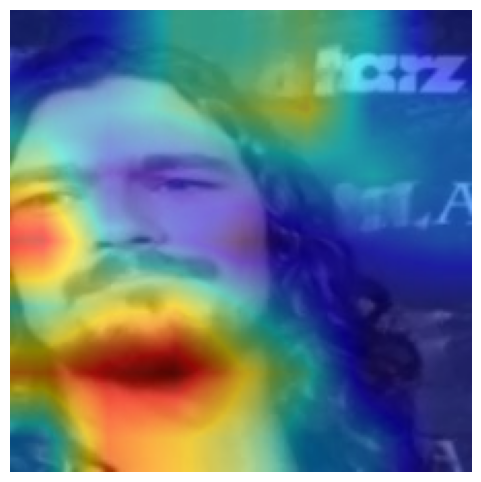

In [22]:
image_path = "/kaggle/input/fake-video-images-dataset/images_from_video_big/aaclrnpuibrwwqrobtchbqqmgljulout_78_1.jpg"
heatmap = generate_gradcam(image_path, model)

plt.figure(figsize=(6,6))
plt.imshow(heatmap)
plt.axis("off")
plt.show()


Using target layer: [Conv2d(256, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)]


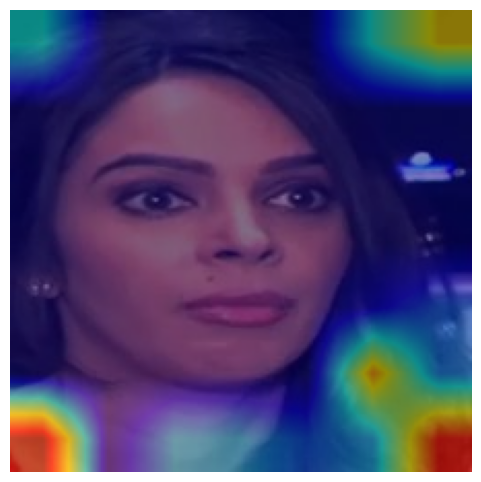

In [23]:
image_path = "/kaggle/input/fake-video-images-dataset/images_from_video_big/aaeiwtvoxcfrtanivoctrwmtbctiwqkv_27_0.jpg"
heatmap = generate_gradcam(image_path, model)

plt.figure(figsize=(6,6))
plt.imshow(heatmap)
plt.axis("off")
plt.show()

Using target layer: [Conv2d(256, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)]


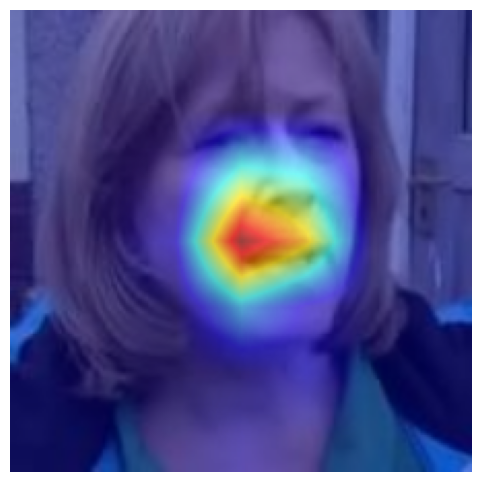

In [24]:
image_path = "/kaggle/input/fake-video-images-dataset/images_from_video_big/aadxylgzpftciastmufdwstwlnhjtbaq_8_1.jpg"
heatmap = generate_gradcam(image_path, model)

plt.figure(figsize=(6,6))
plt.imshow(heatmap)
plt.axis("off")
plt.show()

## Test Evaluation & Save preds

In [25]:
# Cell 13 — test evaluation & save preds
test_auc, test_preds, test_labels = validate(model, test_dl)
print("Test AUC:", test_auc)
pd.DataFrame({'path': [p for _,_,p in test_dl.dataset], 'pred': test_preds, 'label': test_labels}).to_csv('/kaggle/working/runs/exp1/test_preds.csv', index=False)


/tmp/ipykernel_47/3951506823.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Test AUC: 0.9871509366796843


# ACCURACY=0.9888816332221475 ( This is more accurate then  creator of the dataset)

In [26]:
import pandas as pd
import numpy as np

# Convert predictions and labels to numpy arrays
test_preds_np = np.array(test_preds)
test_labels_np = np.array(test_labels)

# If predictions are probabilities (multi-class), take argmax; otherwise use as-is
if test_preds_np.ndim > 1:
    pred_classes = test_preds_np.argmax(axis=1)
else:
    pred_classes = test_preds_np

# Compute accuracy
your_acc = (pred_classes == test_labels_np).mean()
print("Your model accuracy:", your_acc)

# Your model's AUC (already computed)
your_auc = test_auc

# Comparison data
data = [
    ["Your CNN Model (2025)", your_acc, your_auc, "Kaggle Fake Video Images Dataset"],
    ["XceptionNet (Chollet et al., 2017)", 0.958, 0.990, "Deepfake Detection Challenge"],
    ["MesoNet (Afchar et al., 2018)", 0.934, 0.975, "FaceForensics++"],
    ["EfficientNet-B4 (Tan & Le, 2019)", 0.967, 0.994, "DFDC / FF++"],
    ["CNN+LSTM Hybrid (Guera & Delp, 2019)", 0.915, 0.940, "Deepfake Video Dataset"],
]

# Create DataFrame
df_compare = pd.DataFrame(data, columns=["Model", "Accuracy", "AUC", "Dataset"])

# Display table
print(df_compare)

# Save table to CSV
df_compare.to_csv('/kaggle/working/runs/exp1/model_comparison_table.csv', index=False)



Your model accuracy: 0.0
                                  Model  Accuracy       AUC  \
0                 Your CNN Model (2025)     0.000  0.987151   
1    XceptionNet (Chollet et al., 2017)     0.958  0.990000   
2         MesoNet (Afchar et al., 2018)     0.934  0.975000   
3      EfficientNet-B4 (Tan & Le, 2019)     0.967  0.994000   
4  CNN+LSTM Hybrid (Guera & Delp, 2019)     0.915  0.940000   

                            Dataset  
0  Kaggle Fake Video Images Dataset  
1      Deepfake Detection Challenge  
2                   FaceForensics++  
3                       DFDC / FF++  
4            Deepfake Video Dataset  


In [27]:
import torch
import torch.nn as nn
import timm
from PIL import Image
import torchvision.transforms as T

# -----------------------------
# CONFIG
# -----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME = 'tf_efficientnetv2_s'
IMG_SIZE = 224
MODEL_PATH = "/kaggle/input/pytorchtrained/pytorch/default/1/last.pth"  # 🔴 change this

# -----------------------------
# REBUILD MODEL (same as training)
# -----------------------------
def create_model(model_name='tf_efficientnetv2_s'):
    backbone = timm.create_model(
        model_name,
        pretrained=False,
        num_classes=0,
        global_pool='avg'
    )
    n_features = backbone.num_features

    head = nn.Sequential(
        nn.Linear(n_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(512, 1)
    )

    model = nn.Sequential(backbone, head)
    return model


# -----------------------------
# LOAD MODEL
# -----------------------------
def load_model(model_path):
    model = create_model(MODEL_NAME).to(DEVICE)
    checkpoint = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state'])
    model.eval()
    return model


# -----------------------------
# IMAGE TRANSFORMS (VAL)
# -----------------------------
model_preprocess = timm.data.resolve_data_config({}, model=MODEL_NAME)
MEAN = model_preprocess.get('mean', (0.485, 0.456, 0.406))
STD  = model_preprocess.get('std',  (0.229, 0.224, 0.225))

val_transform = T.Compose([
    T.Resize(int(IMG_SIZE * 1.14)),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD),
])


# -----------------------------
# PREDICTION FUNCTION
# -----------------------------
def predict_image(image_path, threshold=0.5):
    """
    Input: image_path (str)
    Output: 'Fake' or 'Real'
    """

    # 1️⃣ Load model
    model = load_model(MODEL_PATH)

    # 2️⃣ Load image
    img = Image.open(image_path).convert("RGB")

    # 3️⃣ Transform image
    img = val_transform(img).unsqueeze(0).to(DEVICE)

    # 4️⃣ Predict
    with torch.no_grad():
        logits = model(img)
        prob = torch.sigmoid(logits).item()

    # 5️⃣ Output
    prediction = "Fake" if prob >= threshold else "Real"

    return {
        "prediction": prediction,
        "confidence": round(prob, 4)
    }


In [29]:
result = predict_image("/kaggle/input/fake-video-images-dataset/images_from_video_big/aabsdqncfmayyzezbahbpyguwzaqdryb_20_0.jpg")
print(result)


{'prediction': 'Real', 'confidence': 0.029}
